In [1]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

# Funcion de limpieza general: Creamos una unica base completa en un excel, con mismas columnas y en el mismo orden.

def limpieza_general():
    ind2004 = pd.read_stata('usu_individual_t104.dta')
    ind2024 = pd.read_excel('usu_individual_T124.xlsx')
    ind2004.set_index('CODUSU', inplace=True)
    ind2024.set_index('CODUSU', inplace=True)
    ind2024 = ind2024.loc[:, ~ind2024.columns.str.contains("CH05")]
    ind2004.columns = ind2004.columns.str.upper()

    # 🔽 Normalizar valores de REGION en ind2004 si son textos
    if 'REGION' in ind2004.columns:
        region_map = {
            'Gran Buenos Aires': 1,
            'NOA': 40,
            'NEA': 41,
            'Cuyo': 42,
            'Pampeana': 43,
            'Patagónica': 44
        }
        ind2004['REGION'] = ind2004['REGION'].replace(region_map)

    # 🔽 Verificar que REGION esté en ind2024 y convertir a numérico
    if 'REGION' in ind2024.columns:
        ind2024['REGION'] = pd.to_numeric(ind2024['REGION'], errors='coerce')

    # 🔽 Emparejar columnas
    cols_2004 = set(ind2004.columns)
    cols_2024 = set(ind2024.columns)

    sobran_2004 = cols_2004 - cols_2024
    sobran_2024 = cols_2024 - cols_2004
    ind2004 = ind2004.drop(columns=sobran_2004)
    ind2024 = ind2024.drop(columns=sobran_2024)

    if ind2024.shape[1] == ind2004.shape[1]:
        print(f"Igual cantidad de columnas: {ind2004.shape[1]}")
    else:
        print(f'No son iguales: 2024: {ind2024.shape[1]}, 2004:{ind2004.shape[1]}')

    ind2024 = ind2024[ind2004.columns]

    # 🔽 Unir bases y exportar
    base_completa = pd.concat([ind2004, ind2024], axis=0)

    variables_elegidas = ['ANO4', 'REGION', 'ESTADO', 'CH04', 'CH06', 'CH10', 'CH12', 'CH13', 'CH14', 
                          'PP04A', 'PP04B_COD', 'PP07C', 'CAT_INAC', 'P21', 'PP3E_TOT', 'PP3F_TOT']
    
    base_completa = base_completa[variables_elegidas]
    base_completa.to_excel('BaseLimpiaEPH.xlsx', index=False)

    print("Archivo exportado a Excel.")



limpieza_general()

def limpieza_edad():
    ind2004 = pd.read_excel('BaseLimpiaEPH.xlsx')
    valores_unicos_2004 = ind2004['CH06'][~ind2004['CH06'].apply(
        lambda x: isinstance(x, (int, float)))].unique()
    print("Valores no numéricos únicos en CH06 (2004):")
    print(valores_unicos_2004)

    año2004 = ind2004['ANO4'] == 2004
    no_numeros = ind2004.loc[año2004, 'CH06'][~ind2004.loc[año2004, 'CH06']
                                              .apply(lambda x: isinstance(x, (int, float)))].unique()
    print("Valores no numéricos únicos en CH06 (2004):", no_numeros)

    reemplazos = {'Menos de 1 año': 1, '98 y más años': 99}
    series_2004 = ind2004.loc[año2004, 'CH06'].astype(str).replace(reemplazos)
    ind2004.loc[año2004, 'CH06'] = pd.to_numeric(series_2004, errors='coerce')

    print('Valores de edad corregidos solo para 2004.')
    ind2004.to_excel('BaseLimpiaEPH.xlsx', index=False)
    print('Archivo guardado')


limpieza_edad()

# Limpiamos la variable "Estado" para que solo tenga valores numéricos en cuanto a la ocupación, desocupación y otros resultados.


def limpieza_estado():
    Est = pd.read_excel('BaseLimpiaEPH.xlsx')

    valores_unicos_2004 = Est['ESTADO'][~Est['ESTADO'].apply(
        lambda x: isinstance(x, (int, float)))].unique()
    print(
        f"Valores no numéricos únicos en ESTADO (2004):{valores_unicos_2004}")

    Est['ESTADO'] = Est['ESTADO'].astype(str)
    Est['ESTADO'] = Est['ESTADO'].replace({
        'Ocupado': 1,
        'Desocupado': 2,
        'Inactivo': 3,
        'Menor de 10 años': 4,
        'Entrevista individual no realizada (no respuesta al cuestion': 0})
    Est['ESTADO'] = pd.to_numeric(Est['ESTADO'], errors='coerce')

    print(f'Valores en ESTADO 2004:{Est['ESTADO'].unique()}')
    print(f'Tipo de valores: {Est['ESTADO'].dtype}')

    Est.to_excel('BaseLimpiaEPH.xlsx', index=False)
    print('Limpieza guardada.')

limpieza_estado()

# Luego de la limpieza, realizamos lo pedido:
# Creamos la variable "edad2", que es todas las edades elevadas al cuadrado, y añadimos la columna a la base.


def edad2():
    var_nueva = pd.read_excel('BaseLimpiaEPH.xlsx')
    var_nueva['edad2'] = np.square(var_nueva['CH06'])
    var_nueva.to_excel('BaseLimpiaEPH.xlsx')
    print('Nueva variable edad2 añadida.')


edad2()

def educ_limpieza():
    df = pd.read_excel('BaseLimpiaEPH.xlsx')
    df['CH10'] = df['CH10'].astype(str)
    df['CH10'] = df['CH10'].replace({
        'No asiste, pero asistió': 2,
        'Sí, asiste': 1,
        'Nunca asistió': 3,
        'Ns./Nr.': 9})
    df['CH10'] = pd.to_numeric(df['CH10'], errors='coerce')

    df['CH12'] = df['CH12'].astype(str).dropna()
    df['CH12'] = df['CH12'].replace({
        'Secundario': 4,
        'Primario': 2,
        'Universitario': 7,
        'Terciario': 6,
        'Jardín/Preescolar': 1,
        'Polimodal': 5,
        'EGB': 3,
        'Educación especial (discapacitado)': 9,
        'Ns./Nr.': 9,
        '99': 9})
    df['CH12'] = pd.to_numeric(df['CH12'], errors='coerce')

    df['CH13'] = df['CH13'].astype(str)
    df['CH13'] = df['CH13'].replace({
        'No': 2,
        'Sí': 1,
        'Ns./Nr.': 9})
    df['CH13'] = pd.to_numeric(df['CH13'], errors='coerce')

    df['CH14'] = df['CH14'].replace({i: f'0{i}' for i in range(0, 10)})
    df['CH14'] = pd.to_numeric(df['CH14'], errors='coerce')

    # Chequeamos los valores unicos de cada variable luego de limpiar.
    print(f'Valores en CH10:{df['CH10'].unique()}')
    print(f'Valores en CH12:{df['CH12'].unique()}')
    print(f'Valores en CH13:{df['CH13'].unique()}')
    print(f'Valores en CH14:{df['CH14'].unique()}')
    df.to_excel('BaseLimpiaEPH.xlsx', index=False)

    # Creamos una función que, en caso de que asista o hayaa asistido a alguna institución de educación, -
    # nos devuelva distintos valores en cada una. Si asiste o asistió a secundaria como última institución -
    # se hace 6 (Por primaria) + el último año cursado.

educ_limpieza()

def educ():
    df = pd.read_excel('BaseLimpiaEPH.xlsx')

    def educ(row):
        if row['CH10'] in [1]:  # Si asiste a alguna institución:
            if row['CH14'] in [99, 98]:
                # Educación especial.
                return 6
            else:
                # No contamos jardín como años de educación.
                if row['CH12'] == 1:
                    return 0
                # Primaria, al consultar por ultimo año cursado, esa es su cantidad de años.
                elif row['CH12'] == 2:
                    return row['CH14']
                # EGB, cant. de años maximo es 9, dirá los años cursados en su respuesta de 'CH14'
                elif row['CH12'] == 3:
                    return row['CH14']
                # Secundaria, 6 de primaria + ultimo año cursado.
                elif row['CH12'] == 4:
                    return 6 + row['CH14']
                # Polimodal, 8 años de EGB + ultimo año cursado.
                elif row['CH12'] == 5:
                    return 9 + row['CH14']
                # Terciario, 12 años de primaria y secundaria + ultimo año cursado.
                elif row['CH12'] == 6:
                    return 12 + row['CH14']
                elif row['CH12'] == 7:  # Univ, lo mismo que terciario.
                    return 12 + row['CH14']
                # Posgrado, asumo 5 años de educación universitaria: 17 + ultimo año cursado
                elif row['CH12'] == 8:
                    return 17 + row['CH14']
                elif row['CH12'] == 9:  # Ed. especial, asumo 6.
                    return row['CH14']
                else:
                    return 0
        elif row['CH10'] in [2]:
            if row['CH13'] in [1]:
                if row['CH14'] in [99, 98]:
                    # Educación especial.
                    return 6
                else:
                    # No contamos jardín como años de educación.
                    if row['CH12'] == 1:
                        return 0
                    # Primaria
                    elif row['CH12'] == 2:
                        return 6
                    # EGB, cant. de años maximo es 9
                    elif row['CH12'] == 3:
                        return 9
                    # Secundaria, 6 de primaria + 6
                    elif row['CH12'] == 4:
                        return 12
                    # Polimodal, 8 años de EGB + 3
                    elif row['CH12'] == 5:
                        return 12
                    # Terciario, 12 años de primaria y secundaria + ultimo año cursado.
                    elif row['CH12'] == 6:
                        return 15
                    elif row['CH12'] == 7:  # Univ, lo mismo que terciario.
                        return 17
                    # Posgrado, asumo 5 años de educación universitaria: 17 + 1 de posgrado.
                    elif row['CH12'] == 8:
                        return 18
                    elif row['CH12'] == 9:  # Ed. especial.
                        return 6
                    else:
                        return 0
            elif row['CH13'] in [2]:
                if row['CH14'] in [99, 98]:
                    # Educación especial.
                    return 6
                else:
                    # No contamos jardín como años de educación.
                    if row['CH12'] == 1:
                        return 0
                    # Primaria, al consultar por ultimo año cursado, esa es su cantidad de años.
                    elif row['CH12'] == 2:
                        return row['CH14']
                    # EGB, cant. de años maximo es 9, dirá los años cursados en su respuesta de 'CH14'
                    elif row['CH12'] == 3:
                        return row['CH14']
                    # Secundaria, 6 de primaria + ultimo año cursado.
                    elif row['CH12'] == 4:
                        return 6 + row['CH14']
                    # Polimodal, 9 años de EGB + ultimo año cursado.
                    elif row['CH12'] == 5:
                        return 9 + row['CH14']
                    # Terciario, 12 años de primaria y secundaria + ultimo año cursado.
                    elif row['CH12'] == 6:
                        return 12 + row['CH14']
                    elif row['CH12'] == 7:  # Univ, lo mismo que terciario.
                        return 12 + row['CH14']
                    # Posgrado, asumo 5 años de educación universitaria: 17 + ultimo año cursado
                    elif row['CH12'] == 8:
                        return 17 + row['CH14']
                    elif row['CH12'] == 9:  # Ed. especial.
                        return row['CH14']
                    else:
                        return 0
        elif row['CH10'] in [3]:  # Si nunca asistió, 0 años de educación.
            return 0
        else:
            return 0
    df['educ'] = df.apply(educ, axis=1)
    df.to_excel('BaseLimpiaEPH.xlsx', index=False)  # Guardamos la variable.
    print('Variable "educ" añadida.')

educ()

def salario_semanal():
    SMVM2004 = 350
    SMVM2024 = 202800
    pp = round(SMVM2024 / SMVM2004, 2)
    print(f'El SMVM de 2024T1 es {pp} veces el SMVM de 2004T1')

    df = pd.read_excel('BaseLimpiaEPH.xlsx')
    df.loc[(df['ANO4'] == 2004) & (df['P21'] > 0), 'salario_semanal'] = (
        df.loc[(df['ANO4'] == 2004) & (df['P21'] > 0), 'P21'] * pp / 21.65) * 5
    df.loc[(df['ANO4'] == 2024) & (df['P21'] > 0), 'salario_semanal'] = ((
        df.loc[(df['ANO4'] == 2024) & (df['P21'] > 0), 'P21']) / 21.65) * 5
    df.to_excel('BaseLimpiaEPH.xlsx', index=False)
    print('Ajuste hecho')
    prom_2004 = np.mean((df.loc[(df['ANO4'] == 2004) & (
        df['salario_semanal'] != 0), 'salario_semanal']) * 4.33)
    prom_2024 = np.mean(df.loc[(df['ANO4'] == 2024) & (df['P21'] != 0), 'P21'])

    # Chequeamos los promedios para verificar que las cantidades no sean absurdas tras el ajuste.
    print(f"Promedio 2004 ajustado: {round(prom_2004, 2)}")
    print(f"Promedio 2024: {round(prom_2024, 2)}")
salario_semanal()

df = pd.read_excel('BaseLimpiaEPH.xlsx')

# Reemplazamos valores inválidos con NaN si existen
df[['PP3E_TOT', 'PP3F_TOT']] = df[['PP3E_TOT', 'PP3F_TOT']].replace([99, 999, 9999], np.nan)

# Creamos la variable 'horastrab'
df['horastrab'] = df['PP3E_TOT'] + df['PP3F_TOT']

# Guardamos nuevamente en el Excel
df.to_excel('BaseLimpiaEPH.xlsx', index=False)
print('Variable "horastrab" añadida')

C:\Users\andre\AppData\Local\Temp\ipykernel_9572\3855592963.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ind2004['REGION'] = ind2004['REGION'].replace(region_map)
C:\Users\andre\AppData\Local\Temp\ipykernel_9572\3855592963.py:30: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  ind2004['REGION'] = ind2004['REGION'].replace(region_map)


Igual cantidad de columnas: 171
Archivo exportado a Excel.
Valores no numéricos únicos en CH06 (2004):
['Menos de 1 año' '98 y más años']
Valores no numéricos únicos en CH06 (2004): ['Menos de 1 año' '98 y más años']
Valores de edad corregidos solo para 2004.
Archivo guardado
Valores no numéricos únicos en ESTADO (2004):['Inactivo' 'Ocupado' 'Desocupado' 'Menor de 10 años'
 'Entrevista individual no realizada (no respuesta al cuestion']
Valores en ESTADO 2004:[3 1 2 4 0]
Tipo de valores: int64
Limpieza guardada.
Nueva variable edad2 añadida.
Valores en CH10:[2 1 3 0 9]
Valores en CH12:[ 4.  2.  7.  6.  0.  1.  5.  3.  9. nan  8.]
Valores en CH13:[2 1 0 9]
Valores en CH14:[ 3. nan  4.  2.  1.  6.  0.  5.  7.  9. 99.  8. 98.]
Variable "educ" añadida.
El SMVM de 2024T1 es 579.43 veces el SMVM de 2004T1
Ajuste hecho
Promedio 2004 ajustado: 330230.47
Promedio 2024: 253270.44
Variable "horastrab" añadida


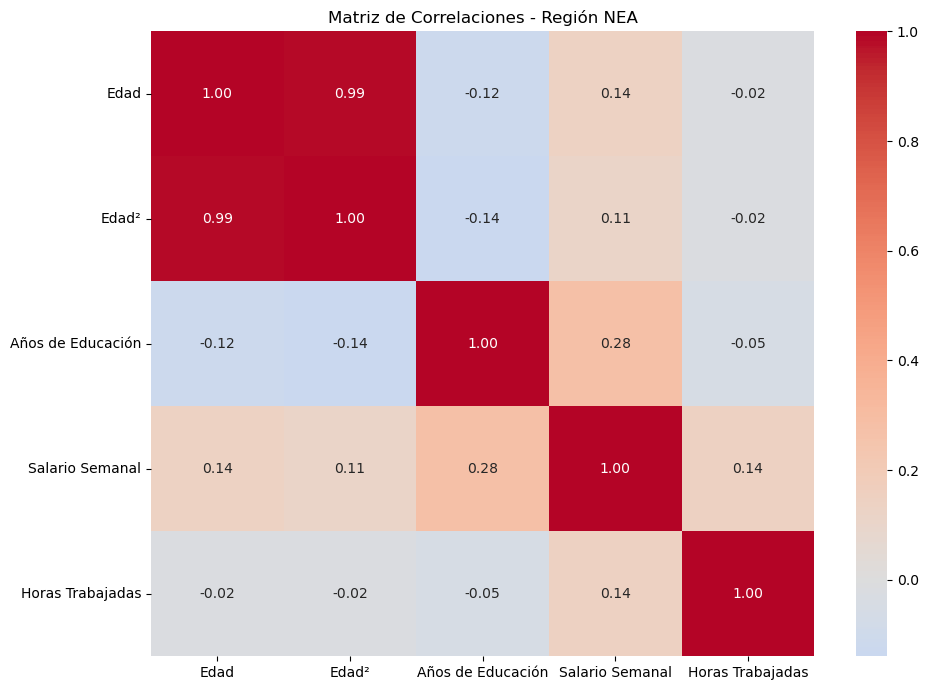

In [2]:
df = pd.read_excel('BaseLimpiaEPH.xlsx')
nea = df[df['REGION'] == 41]

variables = ['CH06', 'edad2', 'educ', 'salario_semanal', 'horastrab']
nea_seleccion = nea[variables]
nea_seleccion = nea_seleccion.dropna()

# Calculamos la matriz de correlaciones
correlacion = nea_seleccion.corr()

nombres_variables = {
    'CH06': 'Edad',
    'edad2': 'Edad²',
    'educ': 'Años de Educación',
    'salario_semanal': 'Salario Semanal',
    'horastrab': 'Horas Trabajadas'
}

correlacion.rename(columns=nombres_variables, index=nombres_variables, inplace=True)

# Grafico
plt.figure(figsize=(10, 7))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Matriz de Correlaciones - Región NEA")
plt.tight_layout()
plt.savefig("matriz_correlaciones_NEA.png", dpi=300)
plt.show()